# Look at O2:CO2 flux phase space

In [1]:
%matplotlib inline
from config_calc import *

import os
import sys
import socket
import numpy as np
import xarray as xr

from datetime import datetime
import grid_tools
import esmlab

import cesm_orcas_sci as cesm
import cam

import matplotlib.pyplot as plt

import xcalendar as xcal
import flux_products

## Observations

In [2]:
file_name = flux_products.files_res('GK01R','f09')
ds = xr.open_dataset(file_name)

file_name = flux_products.files_res('TAK09','f09')
ds = xr.merge((ds,xr.open_dataset(file_name).drop(['time','area'])))

file_name = 'data/f09_f09.nc'
grid = xr.open_dataset(file_name)
ds['lat'] = grid.lat
ds['lon'] = grid.lon
ds.time.values = np.array(['2002-%02d-15'%m for m in range(1,13)]).astype('datetime64[ns]')
ds

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 12)
Coordinates:
  * time      (time) datetime64[ns] 2002-01-15 2002-02-15 ... 2002-12-15
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    area      (lat, lon) float32 ...
    O2_FLUX   (time, lat, lon) float32 ...
    CO2_FLUX  (time, lat, lon) float32 ...

In [3]:
ds.area.values = grid_tools.compute_grid_area(longitude=ds.lon.values,latitude=ds.lat.values)
ds

total area = 5.1008244881083744e+14
check area = 5.1009969907076156e+14


<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 12)
Coordinates:
  * time      (time) datetime64[ns] 2002-01-15 2002-02-15 ... 2002-12-15
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    area      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    O2_FLUX   (time, lat, lon) float32 ...
    CO2_FLUX  (time, lat, lon) float32 ...

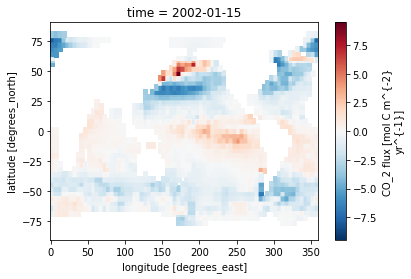

In [4]:
ds.CO2_FLUX.isel(time=0).plot()

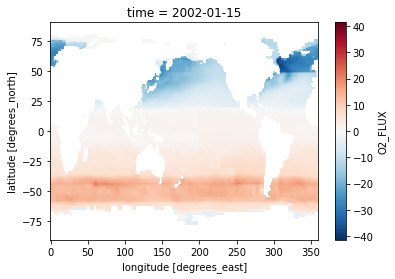

In [5]:
ds.O2_FLUX.isel(time=0).plot()

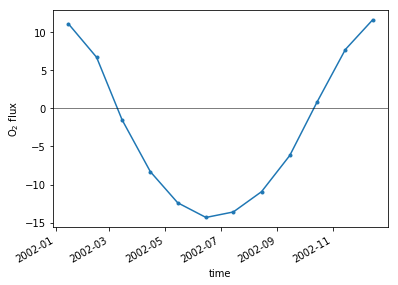

In [6]:
rmask = ds.O2_FLUX.notnull() * ds.area.where((ds.lat<=-44.)).fillna(0.)
wgt = rmask / rmask.sum(dim=['lon','lat'])
o2 = (ds.O2_FLUX * wgt).sum(dim=['lon','lat'])
o2.attrs['long_name'] = 'O$_2$ flux'
o2.plot(marker='.')
plt.axhline(0, linewidth=0.5, color='k')

<xarray.DataArray (time: 12)>
array([-1.056414e+00, -1.157362e+00, -7.446797e-01, -6.638551e-01,
       -5.408479e-01, -3.081616e-01,  4.695706e-04,  3.416058e-01,
        4.341840e-01, -6.847216e-02, -4.266750e-01, -8.209997e-01])
Coordinates:
  * time     (time) datetime64[ns] 2002-01-15 2002-02-15 ... 2002-12-15
Attributes:
    wgtFile:           /glade/p/work/mclong/regrid/weight_files/latlon_4x5_0E...
    src_file_varname:  CO2_FLUX
    src_file:          /glade/p/eol/stephens/longcoll/mclong_calcs/flux_produ...
    long_name:         CO$_2$ flux
    units:             mol C m^{-2} yr^{-1}

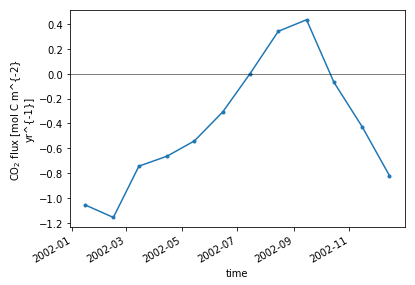

In [7]:
rmask = ds.CO2_FLUX.notnull() * ds.area.where((ds.lat<=-44.)).fillna(0.)
wgt = rmask / rmask.sum(dim=['lon','lat'])
co2 = (ds.CO2_FLUX * wgt).sum(dim=['lon','lat'])
co2.attrs['long_name'] = 'CO$_2$ flux'
co2.plot(marker='.')
plt.axhline(0, linewidth=0.5, color='k')
co2

## CESM Hindcast

In [8]:
pth = '/glade/p/cesm/community/CESM-DPLE/CESM-DPLE_POPCICEhindcast/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.{0}.024901-031612.nc'
ds = xr.Dataset()
for v in ['FG_CO2', 'STF_O2']:
    dsi = xr.open_dataset(pth.format(v),decode_times=False, decode_coords=False)
    ds = xr.merge((ds, dsi))
    
ds = ds.drop([v for v in ds.data_vars if v not in ['TLAT', 'TLONG', 'TAREA', 'KMT', 'FG_CO2', 'STF_O2', 'time', ds.time.bounds]])

ds = ds.where(ds.TLAT <= -44.)
ds = esmlab.statistics.weighted_mean(ds, weights=ds.TAREA, dim=['nlat', 'nlon'])
ds['STF_O2'].values = ds.STF_O2 * 1e-9 * 1e4 * 365. * 86400. * (-1.0)
ds['FG_CO2'].values = ds.FG_CO2 * 1e-9 * 1e4 * 365. * 86400. * (-1.0)

ds.FG_CO2.attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'
ds.STF_O2.attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'
ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:     (d2: 2, time: 816)
Coordinates:
  * time        (time) float64 9.092e+04 9.094e+04 ... 1.157e+05 1.157e+05
Dimensions without coordinates: d2
Data variables:
    TLAT        float64 -58.42
    KMT         float64 44.74
    TAREA       float64 3.838e+13
    TLONG       float64 180.5
    time_bound  (time, d2) float64 9.088e+04 9.092e+04 ... 1.157e+05 1.157e+05
    FG_CO2      (time) float64 -1.34 -1.476 -1.398 ... 0.3621 -0.5579 -1.986
    STF_O2      (time) float64 16.53 10.79 1.881 -5.872 ... -1.649 7.152 17.02

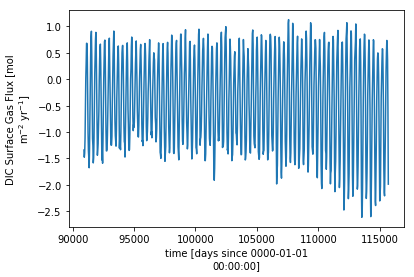

In [9]:
ds.FG_CO2.plot()

In [10]:
dsc_hindcast = esmlab.climatology(ds, freq='mon')
dsc_hindcast

<xarray.Dataset>
Dimensions:     (d2: 2, time: 12)
Coordinates:
  * time        (time) float64 15.49 44.98 74.48 105.0 ... 288.5 319.0 349.5
Dimensions without coordinates: d2
Data variables:
    time_bound  (time, d2) float64 0.0 30.98 30.98 58.98 ... 334.0 334.0 365.0
    FG_CO2      (time) float64 -1.521 -1.546 -1.429 ... 0.3785 -0.3133 -1.173
    STF_O2      (time) float64 15.96 10.24 2.024 -5.58 ... -0.7215 8.832 16.56
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
    TLAT        float64 -58.42
    KMT         float64 44.74
    TAREA       float64 3.838e+13
    TLONG       float64 180.5
Attributes:
    history:  \n2019-04-23 16:12:25.885815 esmlab.climatology(<DATASET>, freq...

### Just the obs

Text(0, 0.5, 'O$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')

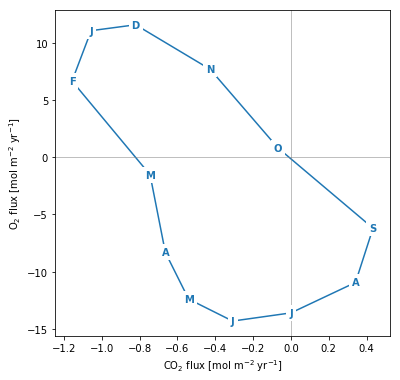

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(co2, o2, marker='o', facecolors='none', edgecolors='none')

p = ax.plot(xr.concat((co2, co2.isel(time=0, drop=False)), dim='time'),
            xr.concat((o2, o2.isel(time=0, drop=False)), dim='time'),'-')

for i in range(12):
    t = ax.text(co2[i], o2[i], xcal.month_letter[i],
                verticalalignment='center',
                horizontalalignment='center',
                fontweight='bold',
                color=p[0].get_color(),
                bbox=dict(boxstyle='square,pad=0.3',fc='white',ec='none'))

ax.axhline(0.,color='gray',linewidth=0.5)
ax.axvline(0.,color='gray',linewidth=0.5)

ax.set_xlabel('CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')
ax.set_ylabel('O$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')

### Obs and hindcast

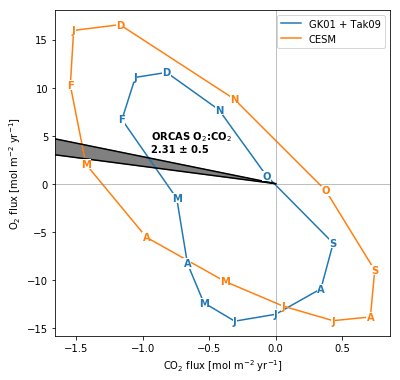

In [12]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

#ax.scatter(co2, o2, marker='o', facecolors='none', edgecolors='none')
#ax.scatter(dsc.FG_CO2, dsc.STF_O2, marker='o', facecolors='none', edgecolors='none')

p = ax.plot(xr.concat((co2,co2.isel(time=0,drop=False)),dim='time'),
            xr.concat((o2,o2.isel(time=0,drop=False)),dim='time'),'-', 
           label='GK01 + Tak09')

p2= ax.plot(xr.concat((dsc_hindcast.FG_CO2 ,dsc_hindcast.FG_CO2.isel(time=0, drop=False)), dim='time'),
            xr.concat((dsc_hindcast.STF_O2, dsc_hindcast.STF_O2.isel(time=0, drop=False)), dim='time'), '-', 
           label='CESM')


plt.legend((p[0], p2[0]), (p[0].get_label(), p2[0].get_label()))

for i in range(12):
    t = ax.text(co2[i],o2[i],xcal.month_letter[i],
                verticalalignment='center',
                horizontalalignment='center',
                fontweight='bold',
                color=p[0].get_color(),
                bbox=dict(boxstyle='square,pad=0.01',fc='white',ec='none'))
    
    t = ax.text(dsc_hindcast.FG_CO2[i],dsc_hindcast.STF_O2[i],xcal.month_letter[i],
            verticalalignment='center',
            horizontalalignment='center',
            fontweight='bold',
            color=p2[0].get_color(),
            bbox=dict(boxstyle='square,pad=0.01', fc='white', ec='none'))

ax.axhline(0.,color='gray',linewidth=0.5)
ax.axvline(0.,color='gray',linewidth=0.5)

ax.set_xlabel('CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')
ax.set_ylabel('O$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')

xlm = ax.get_xlim()
ylm = ax.get_ylim()
x = np.array([0, -100])
y1 = (-2.31 - 0.5) * x
y2 = (-2.31 + 0.5) * x
#ax.plot(x, -2.31 * x, '-')
ax.plot(x, y1, 'k-')
ax.plot(x, y2, 'k-')
ax.fill_between(x, y1, y2, color='gray')

ax.set_xlim(xlm)
ax.set_ylim(ylm)


ax.text(-0.94, 3.4, 'ORCAS O$_2$:CO$_2$\n2.31 ± 0.5', weight='bold')
plt.savefig(f'{diro["fig"]}/o2co2-flux-phase-space-cesm-obs-orcas-constraint.pdf', dpi=300, 
           bbox_inches='tight')

In [13]:
ds = cesm.open_casedata(case,'atm', 'cam.h0', ['SFCO2_OCN', 'SFO2_OCN'], 
                        transformed='so_ocean_mean')

ds = cesm.convert_dataset(ds, case)
ds

NameError: name 'case' is not defined

In [ ]:
dsc_geos5 = ds.groupby('time.month').mean('time').rename({'month': 'time'}).compute()
dsc_geos5

### ORCAS Runs

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

#ax.scatter(co2, o2, marker='o', facecolors='none', edgecolors='none')
#ax.scatter(dsc.FG_CO2, dsc.STF_O2, marker='o', facecolors='none', edgecolors='none')

p = ax.plot(xr.concat((co2,co2.isel(time=0,drop=False)),dim='time'),
            xr.concat((o2,o2.isel(time=0,drop=False)),dim='time'),'-', 
           label='GK01 + Tak09')

p2= ax.plot(xr.concat((dsc_geos5.SFCO2_OCN, dsc_geos5.SFCO2_OCN.isel(time=0, drop=False)), dim='time'),
            xr.concat((dsc_geos5.SFO2_OCN, dsc_geos5.SFO2_OCN.isel(time=0, drop=False)), dim='time'), '-', 
           label='CESM')


plt.legend((p[0], p2[0]), (p[0].get_label(), p2[0].get_label()))

for i in range(12):
    t = ax.text(co2[i],o2[i],xcal.month_letter[i],
                verticalalignment='center',
                horizontalalignment='center',
                fontweight='bold',
                color=p[0].get_color(),
                bbox=dict(boxstyle='square,pad=0.01',fc='white',ec='none'))
    
    t = ax.text(dsc_geos5.SFCO2_OCN[i], dsc_geos5.SFO2_OCN[i], xcal.month_letter[i],
            verticalalignment='center',
            horizontalalignment='center',
            fontweight='bold',
            color=p2[0].get_color(),
            bbox=dict(boxstyle='square,pad=0.01', fc='white', ec='none'))

ax.axhline(0.,color='gray',linewidth=0.5)
ax.axvline(0.,color='gray',linewidth=0.5)

ax.set_xlabel('CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')
ax.set_ylabel('O$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')

xlm = ax.get_xlim()
ylm = ax.get_ylim()
x = np.array([0, -100])
y1 = (-2.31 - 0.5) * x
y2 = (-2.31 + 0.5) * x
#ax.plot(x, -2.31 * x, '-')
ax.plot(x, y1, 'k-')
ax.plot(x, y2, 'k-')
ax.fill_between(x, y1, y2, color='gray')

ax.set_xlim(xlm)
ax.set_ylim(ylm)


ax.text(-0.94, 3.4, 'ORCAS O$_2$:CO$_2$\n2.31 ± 0.5', weight='bold')
plt.savefig(f'{diro["fig"]}/o2co2-flux-phase-space-cesm-geos5-obs-orcas-constraint.pdf', dpi=300, 
           bbox_inches='tight')

In [ ]:
co2.plot()
plt.axhline(0, linewidth=0.5, color='k')

In [ ]:
o2.plot()
plt.axhline(0, linewidth=0.5, color='k')

In [ ]:
x = xr.DataArray(np.arange(1, 13, 1), dims=('time'))
xroll = x.roll(time=3, roll_coords=False)
print(xroll)
print(xroll.roll(time=-3, roll_coords=False))

In [ ]:
def flux_time_integral(da, roll):
    return ((da
             .roll(time=roll, roll_coords=True) * np.roll(xcal.dpm['noleap']/365., roll))
            .cumsum(dim='time').roll(time=-roll, roll_coords=True))

co2_tint = flux_time_integral(co2, roll=3)
o2_tint = flux_time_integral(o2, roll=3)

In [ ]:
co2_tint.plot()

In [ ]:
o2_tint.plot()

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.scatter(co2_tint, o2_tint, marker='o', facecolors='none', edgecolors='none')

p = ax.plot(xr.concat((co2_tint,co2_tint.isel(time=0,drop=False)),dim='time'),
            xr.concat((o2_tint,o2_tint.isel(time=0,drop=False)),dim='time'),'-')

for i in range(12):
    t = ax.text(co2_tint[i],o2_tint[i],xcal.month_letter[i],
                verticalalignment='center',
                horizontalalignment='center',
                fontweight='bold',
                color=p[0].get_color(),
                bbox=dict(boxstyle='square,pad=0.3',fc='white',ec='none'))

ax.axhline(0.,color='gray',linewidth=0.5)
ax.axvline(0.,color='gray',linewidth=0.5)

ax.set_xlabel('CO$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')
ax.set_ylabel('O$_2$ flux [mol m$^{-2}$ yr$^{-1}$]')

In [ ]:
co2.attrs